In [1]:
!nvidia-smi

Tue Mar 30 18:19:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!dpkg -l | grep nvinfer

In [3]:
%%bash
wget -q https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb

dpkg -i nvidia-machine-learning-repo-*.deb
apt-get -qq update

sudo apt-get -qq install libnvinfer5 

pip install -q tensorflow-gpu==2.0.0

Selecting previously unselected package nvidia-machine-learning-repo-ubuntu1804.
(Reading database ... 160980 files and directories currently installed.)
Preparing to unpack nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb ...
Unpacking nvidia-machine-learning-repo-ubuntu1804 (1.0.0-1) ...
Setting up nvidia-machine-learning-repo-ubuntu1804 (1.0.0-1) ...
Selecting previously unselected package libnvinfer5.
(Reading database ... 160983 files and directories currently installed.)
Preparing to unpack .../libnvinfer5_5.1.5-1+cuda10.1_amd64.deb ...
Unpacking libnvinfer5 (5.1.5-1+cuda10.1) ...
Setting up libnvinfer5 (5.1.5-1+cuda10.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.2) ...
/sbin/ldconfig.real: /usr/local/lib/python3.7/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link



W: Target Packages (Packages) is configured multiple times in /etc/apt/sources.list.d/nvidia-machine-learning.list:1 and /etc/apt/sources.list.d/nvidia-ml.list:1
W: Target Packages (Packages) is configured multiple times in /etc/apt/sources.list.d/nvidia-machine-learning.list:1 and /etc/apt/sources.list.d/nvidia-ml.list:1
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
W: Target Packages (Packages) is configured multiple times in /etc/apt/sources.list.d/nvidia-machine-learning.list:1 and /etc/apt/sources.list.d/nvidia-ml.list:1
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll h

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.compiler.tensorrt import trt_convert as trt
from tensorflow.python.saved_model import tag_constants
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

In [5]:
!mkdir ./data
!wget  -qO ./data/img0.JPG "https://upload.wikimedia.org/wikipedia/commons/thumb/9/93/Golden_Retriever_Carlos_%2810581910556%29.jpg/640px-Golden_Retriever_Carlos_%2810581910556%29.jpg"
!wget  -qO ./data/img1.JPG "https://upload.wikimedia.org/wikipedia/commons/thumb/6/62/Red-shouldered_Hawk_%28Buteo_lineatus%29_-_Blue_Cypress_Lake%2C_Florida.jpg/407px-Red-shouldered_Hawk_%28Buteo_lineatus%29_-_Blue_Cypress_Lake%2C_Florida.jpg"
!wget  -qO ./data/img2.JPG "https://upload.wikimedia.org/wikipedia/commons/thumb/2/28/Ostrich_male_RWD.jpg/636px-Ostrich_male_RWD.jpg"
!wget  -qO ./data/img3.JPG "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ed/Working_pay_phone%2C_Jensen_Beach%2C_Florida%2C_September_4%2C_2012_001.JPG/360px-Working_pay_phone%2C_Jensen_Beach%2C_Florida%2C_September_4%2C_2012_001.JPG"

In [6]:
model = InceptionV3(weights = 'imagenet')

96116736/96112376 [==============================] - 1s 0us/step


In [2]:
def show_predictions(model):
  for i in range(4):
    img_path = './data/img%d.JPG'%i
    img = image.load_img(img_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    preds = model.predict(x)
    print('{} - Predicted: {}'.format(img_path, decode_predictions(preds, top=3)[0]))

    plt.subplot(2,2,i+1)
    plt.imshow(img);
    plt.axis('off');
    plt.title(decode_predictions(preds, top=3)[0][0][1])

In [8]:
tf.saved_model.save(model , 'inceptionv3_saved_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: inceptionv3_saved_model/assets


In [3]:
def batch_input(batch_size = 8):
  batched_input = np.zeros((batch_size , 299 , 299 , 3), dtype = np.float32)

  for i in range(batch_size):
    img_path = './data/img%d.JPG' % (i % 4)
    img = image.load_img(img_path , target_size = (299 , 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x , axis = 0)
    batched_input[i, :] = x

    batched_input = tf.constant(batched_input)
    return batched_input

In [4]:
batched_input = batch_input(batch_size = 32)

In [5]:
def load_tf_saved_model(input_saved_model_dir):
  print(f'Loading saved model {input_saved_model_dir}....')
  saved_model_loaded = tf.saved_model.load(input_saved_model_dir , tags = [tag_constants.SERVING])
  return saved_model_loaded

In [12]:
saved_model = load_tf_saved_model('/content/inceptionv3_saved_model')

Loading saved model /content/inceptionv3_saved_model....


In [13]:
infer = saved_model.signatures['serving_default']
print(infer.structured_outputs)

{'predictions': TensorSpec(shape=(None, 1000), dtype=tf.float32, name='predictions')}


In [6]:
def predict_and_benchmark_throughput(batched_input, infer, N_warmup_run=50, N_run=1000):

  elapsed_time = []
  all_preds = []
  batch_size = batched_input.shape[0]

  for i in range(N_warmup_run):
    labeling = infer(batched_input)
    preds = labeling['predictions'].numpy()

  for i in range(N_run):
    start_time = time.time()

    labeling = infer(batched_input)

    preds = labeling['predictions'].numpy()

    end_time = time.time()

    elapsed_time = np.append(elapsed_time, end_time - start_time)
    
    all_preds.append(preds)

    if i % 50 == 0:
      print('Steps {}-{} average: {:4.1f}ms'.format(i, i+50, (elapsed_time[-50:].mean()) * 1000))

  print('Throughput: {:.0f} images/s'.format(N_run * batch_size / elapsed_time.sum()))
  return all_preds

In [15]:
print('Throughput for baseline InceptionV3 model is:')
all_predictions = predict_and_benchmark_throughput(batched_input , infer , N_warmup_run=50 , N_run = 1000)

Throughput for baseline InceptionV3 model is:
Steps 0-50 average: 74.1ms
Steps 50-100 average: 74.5ms
Steps 100-150 average: 74.4ms
Steps 150-200 average: 74.5ms
Steps 200-250 average: 74.6ms
Steps 250-300 average: 74.3ms
Steps 300-350 average: 74.4ms
Steps 350-400 average: 74.5ms
Steps 400-450 average: 74.5ms
Steps 450-500 average: 74.5ms
Steps 500-550 average: 74.6ms
Steps 550-600 average: 74.6ms
Steps 600-650 average: 74.4ms
Steps 650-700 average: 74.5ms
Steps 700-750 average: 74.7ms
Steps 750-800 average: 74.9ms
Steps 800-850 average: 74.3ms
Steps 850-900 average: 74.3ms
Steps 900-950 average: 74.4ms
Steps 950-1000 average: 74.4ms
Throughput: 430 images/s


In [7]:
def show_predictions(model):

  img_path = './data/img0.JPG'  
  img = image.load_img(img_path, target_size=(299, 299))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  x = tf.constant(x)

  labeling = model(x)
  preds = labeling['predictions'].numpy()
  
  print('{} - Predicted: {}'.format(img_path, decode_predictions(preds, top=3)[0]))
  plt.subplot(2,2,1)
  plt.imshow(img);
  plt.axis('off');
  plt.title(decode_predictions(preds, top=3)[0][0][1])

40960/35363 [==================================] - 0s 0us/step
./data/img0.JPG - Predicted: [('n02099601', 'golden_retriever', 0.6146083), ('n02099712', 'Labrador_retriever', 0.2392583), ('n02104029', 'kuvasz', 0.006721575)]


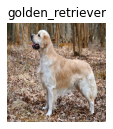

In [17]:
show_predictions(infer)

In [8]:
def convert_to_trt_graph_and_save(precision_mode = 'float32' , 
                                  input_saved_model_dir = 'inceptionv3_saved_model' , 
                                  caliberation_data = batched_input):
  if(precision_mode == 'float32'):
    precision_mode = trt.TrtPrecisionMode.FP32
    converted_save_suffix = '_TFTRT_FP32'

  if(precision_mode == 'float16'):
    precision_mode = trt.TrtPrecisionMode.FP16
    converted_save_suffix = '_TFTRT_FP16'

  if(precision_mode == 'int8'):
    precision_mode = trt.TrtPrecisionMode.INT8
    converted_save_suffix = '_TFTRT_INT8'

  output_saved_model_dir = input_saved_model_dir + converted_save_suffix
  conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
      precision_mode = precision_mode , 
      max_workspace_size_bytes = 8000000000
  )
  converter = trt.TrtGraphConverterV2(
      input_saved_model_dir = input_saved_model_dir,
      conversion_params = conversion_params
  )
  print(f'Converting {input_saved_model_dir} to TF-TRT graph precision mode {precision_mode}....')

  if precision_mode == trt.TrtPrecisionMode.INT8:
    def caliberation_input_fn():
      yield (caliberation_data , )
    converter.convert(calibration_input_fn = caliberation_input_fn)
  else:

    converter.convert()
  print(f'Saving converted model to {output_saved_model_dir}')
  converter.save(output_saved_model_dir = output_saved_model_dir)
  print('Complete')


In [19]:
convert_to_trt_graph_and_save(precision_mode = 'float32' , input_saved_model_dir= 'inceptionv3_saved_model')

INFO:tensorflow:Linked TensorRT version: (5, 1, 5)
INFO:tensorflow:Loaded TensorRT version: (5, 1, 5)
INFO:tensorflow:Running against TensorRT version 5.1.5
Converting inceptionv3_saved_model to TF-TRT graph precision mode FP32....
Saving converted model to inceptionv3_saved_model_TFTRT_FP32
INFO:tensorflow:Assets written to: inceptionv3_saved_model_TFTRT_FP32/assets
Complete


In [20]:
saved_model_loaded = load_tf_saved_model('/content/inceptionv3_saved_model_TFTRT_FP32')  

Loading saved model /content/inceptionv3_saved_model_TFTRT_FP32....


In [21]:
infer = saved_model_loaded.signatures['serving_default']

In [22]:
print('Throughput after converting model to TF-TRT graph precision mode Float32:')
all_preds = predict_and_benchmark_throughput(batched_input , infer , N_warmup_run=50 , N_run=1000)

Throughput after converting model to TF-TRT graph precision mode Float32:
Steps 0-50 average: 58.0ms
Steps 50-100 average: 57.6ms
Steps 100-150 average: 57.8ms
Steps 150-200 average: 57.6ms
Steps 200-250 average: 57.6ms
Steps 250-300 average: 57.6ms
Steps 300-350 average: 57.7ms
Steps 350-400 average: 57.6ms
Steps 400-450 average: 57.6ms
Steps 450-500 average: 57.5ms
Steps 500-550 average: 57.6ms
Steps 550-600 average: 57.7ms
Steps 600-650 average: 57.5ms
Steps 650-700 average: 57.6ms
Steps 700-750 average: 57.5ms
Steps 750-800 average: 57.6ms
Steps 800-850 average: 57.6ms
Steps 850-900 average: 57.6ms
Steps 900-950 average: 57.6ms
Steps 950-1000 average: 57.6ms
Throughput: 556 images/s


./data/img0.JPG - Predicted: [('n02099601', 'golden_retriever', 0.61460805), ('n02099712', 'Labrador_retriever', 0.2392582), ('n02104029', 'kuvasz', 0.006721559)]


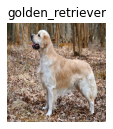

In [23]:
show_predictions(infer)

In [24]:
convert_to_trt_graph_and_save(precision_mode = 'float16',
                              input_saved_model_dir = 'inceptionv3_saved_model')

INFO:tensorflow:Linked TensorRT version: (5, 1, 5)
INFO:tensorflow:Loaded TensorRT version: (5, 1, 5)
INFO:tensorflow:Running against TensorRT version 5.1.5
Converting inceptionv3_saved_model to TF-TRT graph precision mode FP16....
Saving converted model to inceptionv3_saved_model_TFTRT_FP16
INFO:tensorflow:Assets written to: inceptionv3_saved_model_TFTRT_FP16/assets
Complete


In [26]:
saved_model_loaded = load_tf_saved_model('inceptionv3_saved_model_TFTRT_FP16')
infer = saved_model_loaded.signatures['serving_default']

Loading saved model inceptionv3_saved_model_TFTRT_FP16....


In [27]:
print('Throughput after converting model to TF-TRT graph precision mode Float16:')
all_preds = predict_and_benchmark_throughput(batched_input , infer)

Throughput after converting model to TF-TRT graph precision mode Float16:
Steps 0-50 average: 57.5ms
Steps 50-100 average: 57.6ms
Steps 100-150 average: 57.6ms
Steps 150-200 average: 57.8ms
Steps 200-250 average: 57.6ms
Steps 250-300 average: 57.5ms
Steps 300-350 average: 57.7ms
Steps 350-400 average: 57.5ms
Steps 400-450 average: 57.8ms
Steps 450-500 average: 57.6ms
Steps 500-550 average: 57.6ms
Steps 550-600 average: 57.7ms
Steps 600-650 average: 57.6ms
Steps 650-700 average: 57.6ms
Steps 700-750 average: 57.8ms
Steps 750-800 average: 57.7ms
Steps 800-850 average: 57.6ms
Steps 850-900 average: 57.7ms
Steps 900-950 average: 57.6ms
Steps 950-1000 average: 57.7ms
Throughput: 555 images/s


In [9]:
convert_to_trt_graph_and_save(precision_mode='int8' , input_saved_model_dir='inceptionv3_saved_model')

INFO:tensorflow:Linked TensorRT version: (5, 1, 5)
INFO:tensorflow:Loaded TensorRT version: (5, 1, 5)
INFO:tensorflow:Running against TensorRT version 5.1.5
Converting inceptionv3_saved_model to TF-TRT graph precision mode INT8....
Saving converted model to inceptionv3_saved_model_TFTRT_INT8
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: inceptionv3_saved_model_TFTRT_INT8/assets
Complete


In [10]:
saved_model_loaded = load_tf_saved_model('inceptionv3_saved_model_TFTRT_INT8')
infer = saved_model_loaded.signatures['serving_default']

Loading saved model inceptionv3_saved_model_TFTRT_INT8....


In [11]:
print('Throughput after converting model to TF-TRT graph precision mode INT8:')
all_preds = predict_and_benchmark_throughput(batched_input , infer)

Throughput after converting model to TF-TRT graph precision mode INT8:
Steps 0-50 average: 35.5ms
Steps 50-100 average: 35.6ms
Steps 100-150 average: 35.6ms
Steps 150-200 average: 35.6ms
Steps 200-250 average: 35.6ms
Steps 250-300 average: 35.6ms
Steps 300-350 average: 35.6ms
Steps 350-400 average: 35.5ms
Steps 400-450 average: 35.5ms
Steps 450-500 average: 35.7ms
Steps 500-550 average: 35.5ms
Steps 550-600 average: 35.6ms
Steps 600-650 average: 35.6ms
Steps 650-700 average: 35.6ms
Steps 700-750 average: 35.8ms
Steps 750-800 average: 35.6ms
Steps 800-850 average: 35.5ms
Steps 850-900 average: 35.6ms
Steps 900-950 average: 35.5ms
Steps 950-1000 average: 35.6ms
Throughput: 899 images/s


./data/img0.JPG - Predicted: [('n02099601', 'golden_retriever', 0.61567456), ('n02099712', 'Labrador_retriever', 0.23709424), ('n02104029', 'kuvasz', 0.006797108)]


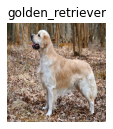

In [13]:
show_predictions(infer)